In [1]:
import pandas as pd
import numpy as np
import random
import requests
import pickle
import sys
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets
from collections import defaultdict

In [2]:
# -- RDKit
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw, PandasTools
from rdkit.Chem.Draw import IPythonConsole
print("RDKit Version: ", rdkit.__version__)

RDKit Version:  2022.09.5


In [3]:
import Bio.PDB as bp

In [4]:
ipywidgets.__version__

'8.0.5'

NOTE: Some cells are commented out or marked as 'raw' because they have been already executed, and we're reading their results as pickled data.

# Functions

In [5]:
def count_entries(df):
    print("Total # records        : ", len(df) )
    print("Unique PDBIDs          : ", len(df.PDB_ID.unique()) )
    print("Membrane Proteins      : ", len(df.loc[ df.IS_MEMBRANE == True ].PDB_ID.unique()))

In [6]:
def has_invalid_atoms(smiles, min_size=10):
    invalid = False
    try:
        mol = Chem.MolFromSmiles(smiles, sanitize=False)
        if mol:
            if len(mol.GetAtoms()) < min_size:
                invalid=True
            else:
                for atom in mol.GetAtoms():
                    symb = atom.GetSymbol()
                    #print(f"{symb}, ", end="")
                    if atom.GetSymbol() not in medchem_atoms: 
                        invalid = True
        else:
            invalid = True
    except:
        invalid = True
    return invalid

In [7]:
# Fix resolutions
def convert_to_float(string):
    value = string
    if isinstance(value,str):
        while value[:1] == "[":
            value = value[1:-1]
        try:
            return float(value)
        except:
            return value
    else:
        return value

def is_float(string):
    value = string
    if type(value) == float:
        return True
    else:
        return False
    
def resolution_lists_to_float(string):
    value = string
    if type(value) == str:
        res_list = [float(x) for x in value.split(',')]
        return min(res_list)
    else:
        return value

In [8]:
def count_ligand_atoms(df):
    atom_present_in_entries = defaultdict(lambda:0)

    for lig in tqdm(df.index):
        smi = df.loc[lig].LIG_SMILES
        try:
            mol = Chem.MolFromSmiles(smi, sanitize=False)
            if mol:
                atom_present_in_mol = defaultdict(lambda : False)
                for atom in mol.GetAtoms():
                     atom_present_in_mol[atom.GetSymbol()] = True
            #    print(atom_present_in_mol)

                for atom in atom_present_in_mol.keys():
                    atom_present_in_entries[atom] += df.loc[lig].Count
        except:
            pass
    atom_present_in_entries.pop('H',None)
    return pd.DataFrame({"ATOM":atom_present_in_entries.keys(),
                           "N_ENTRIES":atom_present_in_entries.values()}).sort_values(by="N_ENTRIES", ascending=False)

In [9]:
def plot_ligand_atom_data(atom_count):
    fig, ax = plt.subplots(figsize=(15,6))
    ax= sns.barplot(data=atom_count.head(40), x='ATOM', y='N_ENTRIES',
                    linewidth=1,edgecolor="black")
    ax.grid(color='lightgrey', ls="--")
    for i in ax.containers:
        ax.bar_label(i, rotation=45)
    return

In [10]:
def plot_common_ligands(lig_data):
    fig, ax = plt.subplots(figsize=(15,6))
    ax= sns.barplot(data=lig_data.head(50), x='LIG_ID', y='Count',
                    linewidth=1,edgecolor="black")
    ax.grid(color='lightgrey', ls="--")
    plt.xticks(rotation = 90);
    return

# Filter the Results
There are 104,477 entries in PDB that are PROTEINS and have ligands. However, not all of those are small-molecules of interest. Among the 'ligands' we have:

- (Real) small-molecule ligands of interest
- Crystallization molecules such as GOL, EDO, etc.
- Ions, such as NA, CL, ACT...

There doesn't seem to be any way to filter the results to get only entries with small molecules, so we have to get each entry and filter them here.

# Looking at the results

After downloading the data, here we treat it.

Non-specific ligands have already been removed in the creation of the DataFrame, i nthe `pdbquery.ipynb` notebook. Here we continue from that point.

In [11]:
pdb_data = pd.read_pickle("pdb_info_df.pkl")

In [12]:
pdb_data.sample(5)

,PDB_ID,RESOLUTION,POLY_NAME,POLY_TYPE,POLY_CHAINS,IS_MEMBRANE,LIG_ID,LIG_CHAINS,LIG_NAME,LIG_SMILES,LIG_TYPE,LIG_MW,INVESTIGN?
113152,5VFD,[1.93],Beta-lactamase,Protein,['A'],False,9CP,['A'],"(2S,5R)-1-formyl-4-methyl-5-[(sulfooxy)amino]-...",CC1=C[C@H](N(C[C@@H]1NOS(=O)(=O)O)C=O)C(=O)N,non-polymer,279.270,0.0
32683,6F3R,[1.9],"Glycogen phosphorylase, muscle form",Protein,['A'],False,CKZ,['A'],"(2~{S},3~{R},4~{R},5~{S},6~{R})-2-[5-(9~{H}-fl...",c1ccc-2c(c1)Cc3c2ccc(c3)c4[nH]c(nn4)[C@H]5[C@@...,non-polymer,395.409,0.0
46452,4HY6,[1.649],Heat shock protein HSP 90-alpha,Protein,['A'],False,FJ1,['A'],"6,6-dimethyl-3-(trifluoromethyl)-1,5,6,7-tetra...",CC1(Cc2c(c(n[nH]2)C(F)(F)F)C(=O)C1)C,non-polymer,232.202,0.0
221583,5JSY,[1.04],"Periplasmic [NiFeSe] hydrogenase, small subunit",Protein,['A'],False,FE2,['B'],FE (II) ION,[Fe+2],non-polymer,55.845,0.0
203505,6W5J,[1.85],3C-LIKE PROTEASE,Protein,"['B', 'A']",False,TKS,"['B', 'A']",2-(3-chlorophenyl)-2-methylpropyl [(2S)-3-cycl...,CC(C)(COC(=O)N[C@@H](CC1CCCCC1)C(=O)N[C@@H](C[...,non-polymer,554.142,1.0


In [13]:
# Fix the resolutions
pdb_data['RESOLUTION'] = pdb_data['RESOLUTION'].apply(convert_to_float)
pdb_data['FLOAT_RES'] = pdb_data.RESOLUTION.apply(is_float)
pdb_data['RESOLUTION'] = pdb_data['RESOLUTION'].apply(resolution_lists_to_float)
pdb_data.drop(columns=['FLOAT_RES'], inplace=True)

In [14]:
count_entries(pdb_data)

Total # records        :  225244
Unique PDBIDs          :  87575
Membrane Proteins      :  2626


In [15]:
#with open('failed.pkl', 'rb') as infile:
#    failed = pickle.load(infile)
#failed

In [16]:
# Drop duplicates of ligand-protein system
pdb_data.drop_duplicates(subset=['PDB_ID','LIG_ID'], inplace=True)
count_entries(pdb_data)

Total # records        :  154265
Unique PDBIDs          :  87575
Membrane Proteins      :  2626


In [17]:
# Drop ligands that are too large or too small
pdb_data = pdb_data.drop( pdb_data[ pdb_data.LIG_MW > 700 ].index )
pdb_data = pdb_data.drop( pdb_data[ pdb_data.LIG_MW < 50    ].index )

count_entries(pdb_data)

Total # records        :  100223
Unique PDBIDs          :  71553
Membrane Proteins      :  2264


<Axes: xlabel='LIG_MW', ylabel='Count'>

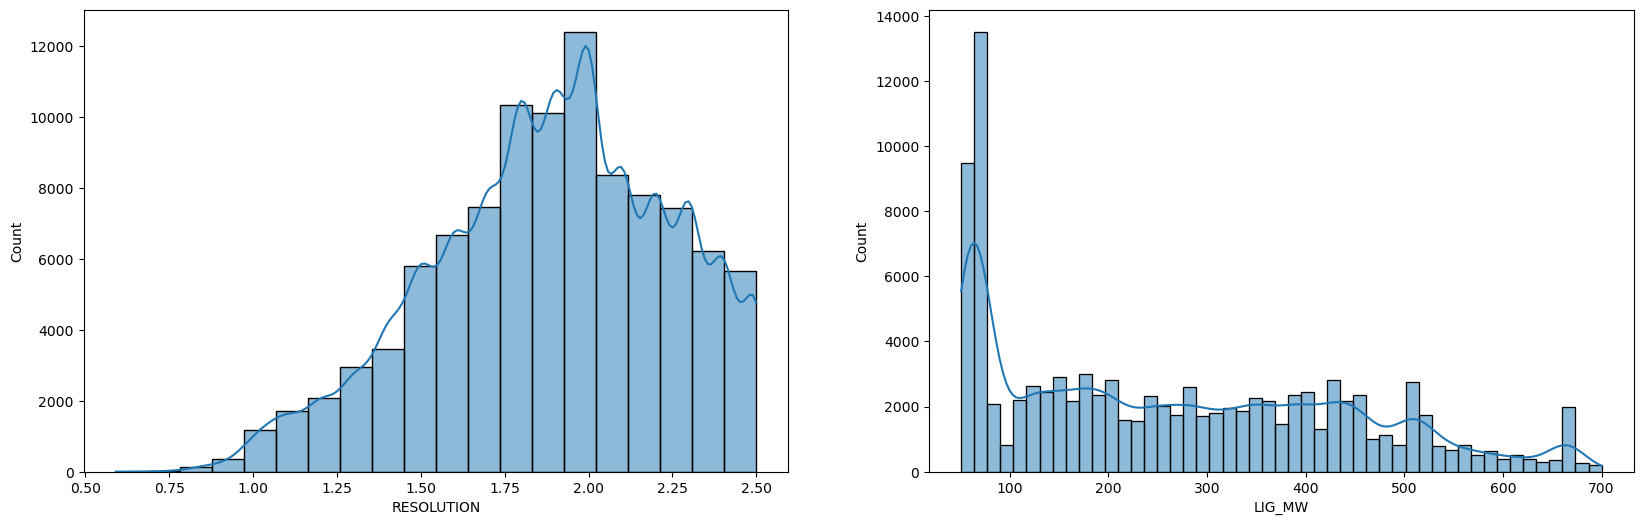

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
sns.histplot(data=pdb_data, x="RESOLUTION", bins=20, ax=ax[0], kde=True)
sns.histplot(data=pdb_data, x="LIG_MW", ax = ax[1], kde=True)

# Ligand Atom Types

In [19]:
lig_data = pd.DataFrame({'LIG_ID':pdb_data['LIG_ID'].value_counts().index, 'Count':pdb_data['LIG_ID'].value_counts()}).reset_index()
lig_data = pd.merge(lig_data, pdb_data.drop_duplicates(subset='LIG_ID'))[['LIG_ID','LIG_NAME','LIG_SMILES','LIG_MW','Count']]

In [20]:
lig_data

,LIG_ID,LIG_NAME,LIG_SMILES,LIG_MW,Count
0,ZN,ZINC ION,[Zn+2],65.409,12520
1,MN,MANGANESE (II) ION,[Mn+2],54.938,2636
2,NI,NICKEL (II) ION,[Ni+2],58.693,1742
3,FE,FE (III) ION,[Fe+3],55.845,1554
4,ADP,ADENOSINE-5'-DIPHOSPHATE,c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3...,427.201,1484
...,...,...,...,...,...
27895,R5W,3-(3-(but-3-yn-1-yl)-3H-diazirin-3-yl)-N-(3-me...,Cc1nnc2n1cccc2NC(=O)CCC3(NN3)CCC#C,298.343,1
27896,6MS,"[6-(2-amino-6-oxo-1,6-dihydro-9H-purin-9-yl)he...",c1nc2c(n1CCCCCCP(=O)(O)O)N=C(NC2=O)N,315.265,1
27897,KWB,5-cyclohexyl-2-hydroxybenzoate,c1cc(c(cc1C2CCCCC2)C(=O)[O-])O,219.256,1
27898,D1N,"NAPHTHALENE-1,2-DIOL",c1ccc2c(c1)ccc(c2O)O,160.169,1


## Remove entries where the ligand has atoms beyond the MedChem set
Here we remove entries where the ligand either:
- Contains atoms not in the 'C','N','O','H','S','P','F','Cl','Br','I' list;
- Contains less than 10 heavy atoms

In [21]:
medchem_atoms = ['C','N','O','H','S','P','F','Cl','Br','I']

In [22]:
lig_data['HAS_INVALID_SMILES'] = lig_data.LIG_SMILES.apply(has_invalid_atoms)

len(lig_data), lig_data.HAS_INVALID_SMILES.sum()

(27900, 2156)

In [23]:
# Store info on invalid ligands
invalid_atoms_ligands = lig_data.loc[ lig_data.HAS_INVALID_SMILES == True ].copy(deep=True)
invalid_atoms_ligands.sample(5)

,LIG_ID,LIG_NAME,LIG_SMILES,LIG_MW,Count,HAS_INVALID_SMILES
4409,AKB,2-AMINO-3-KETOBUTYRIC ACID,CC(=O)[C@@H](C(=O)O)N,117.103,2,True
324,BO3,BORIC ACID,B(O)(O)O,61.833,26,True
922,4MO,MOLYBDENUM(IV) ION,[Mo+4],95.940,8,True
916,TAN,"2,2-dimethylpropanenitrile",CC(C)(C)C#N,83.132,8,True
3347,1EC,[(5R)-5-amino-5-carboxy-8-hydroxyoctyl](trihyd...,[B-](CCCC[C@@](CCCO)(C(=O)O)N)(O)(O)O,250.077,2,True


In [24]:
# Remove non-HCNOSPX ligands
for ligid in tqdm(invalid_atoms_ligands.LIG_ID):
    indexes_to_drop = pdb_data[ pdb_data.LIG_ID == ligid ].index
    pdb_data.drop(index=indexes_to_drop, inplace=True)

  0%|          | 0/2156 [00:00<?, ?it/s]

In [25]:
count_entries(pdb_data)

Total # records        :  64567
Unique PDBIDs          :  53992
Membrane Proteins      :  1970


<Axes: xlabel='LIG_MW', ylabel='Count'>

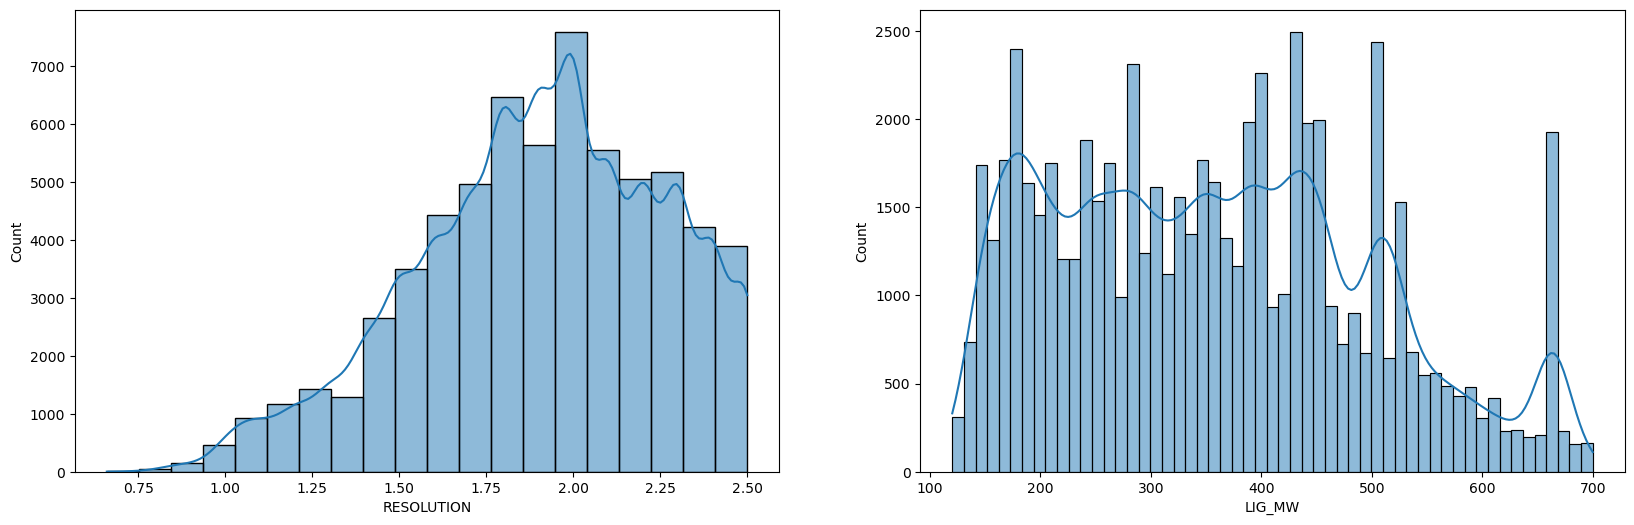

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
sns.histplot(data=pdb_data, x="RESOLUTION", bins=20, ax=ax[0], kde=True)
sns.histplot(data=pdb_data, x="LIG_MW", ax = ax[1], kde=True)

# Check the ligands

In [27]:
# Rebuild lig_data
lig_data = pd.DataFrame({'LIG_ID':pdb_data['LIG_ID'].value_counts().index, 'Count':pdb_data['LIG_ID'].value_counts()}).reset_index()
lig_data = pd.merge(lig_data, pdb_data.drop_duplicates(subset='LIG_ID'))[['LIG_ID','LIG_NAME','LIG_SMILES','LIG_MW','Count']]
len(lig_data)

25744

## Most Common Ligands

In [28]:
lig_data.head(40)

,LIG_ID,LIG_NAME,LIG_SMILES,LIG_MW,Count
0,ADP,ADENOSINE-5'-DIPHOSPHATE,c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3...,427.201,1484
1,NAD,NICOTINAMIDE-ADENINE-DINUCLEOTIDE,c1cc(c[n+](c1)[C@H]2[C@@H]([C@@H]([C@H](O2)CO[...,663.425,1333
2,FMN,FLAVIN MONONUCLEOTIDE,Cc1cc2c(cc1C)N(C3=NC(=O)NC(=O)C3=N2)C[C@@H]([C...,456.344,1139
3,GDP,GUANOSINE-5'-DIPHOSPHATE,c1nc2c(n1[C@H]3[C@@H]([C@@H]([C@H](O3)CO[P@](=...,443.201,1024
4,ATP,ADENOSINE-5'-TRIPHOSPHATE,c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3...,507.181,888
5,SAH,S-ADENOSYL-L-HOMOCYSTEINE,c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3...,384.411,840
6,H4B,"5,6,7,8-TETRAHYDROBIOPTERIN",C[C@@H]([C@@H]([C@H]1CNC2=C(N1)C(=O)NC(=N2)N)O)O,241.247,569
7,AMP,ADENOSINE MONOPHOSPHATE,c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3...,347.221,553
8,ANP,PHOSPHOAMINOPHOSPHONIC ACID-ADENYLATE ESTER,c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3...,506.196,547
9,GTP,GUANOSINE-5'-TRIPHOSPHATE,c1nc2c(n1[C@H]3[C@@H]([C@@H]([C@H](O3)CO[P@](=...,523.180,474


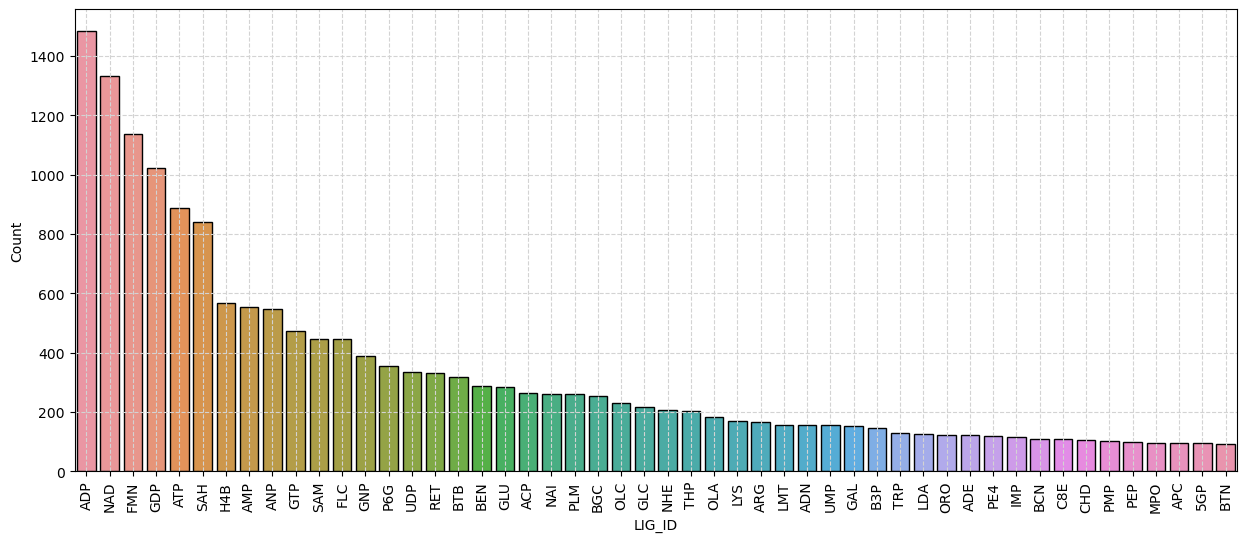

In [29]:
plot_common_ligands(lig_data)

  0%|          | 0/25744 [00:00<?, ?it/s]

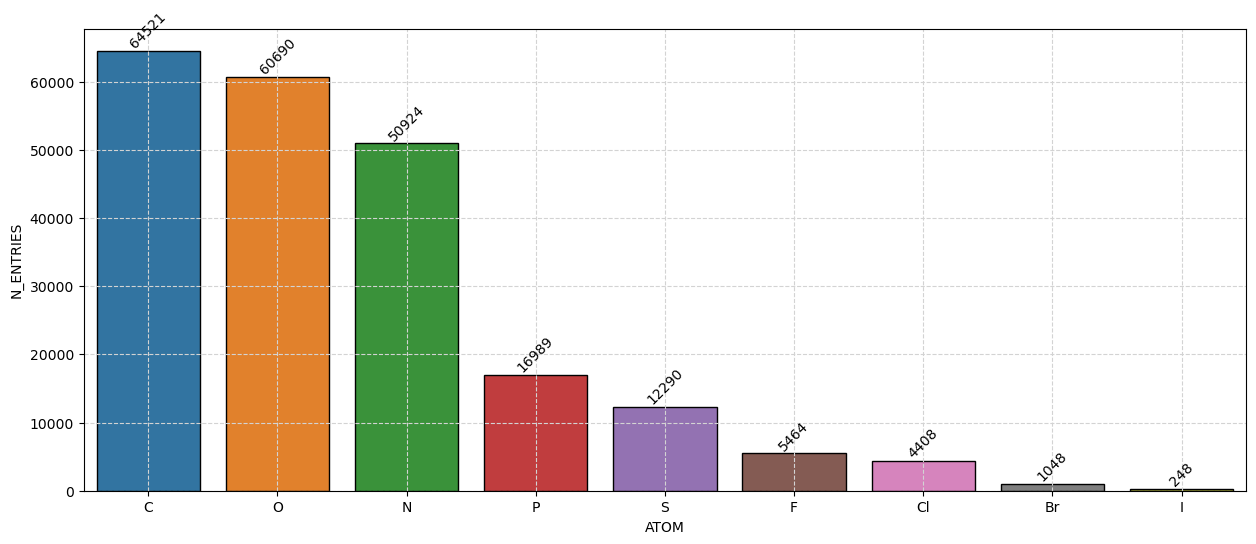

In [30]:
atom_count = count_ligand_atoms(lig_data)
plot_ligand_atom_data(atom_count)

(this shows how many DataFrame rows contains ligands with at last one of those atoms. A single PDBID may have multiple instances of ligands, resulting in more instances of the atoms than unique PDBIDs.)

## Ligands with 2-letter symbols

In [31]:
pdb_data.loc[ pdb_data.LIG_ID.str.len() == 2 ].LIG_ID.unique()

array(['PC', 'EP', 'DC', '5X', 'AS', 'ET', 'AA', 'T3', 'DT', '5H', '1N',
       'DU', 'NQ', 'AO', 'MC', 'Y3', 'DG', 'DA', 'CG', 'VA', 'DI', 'IU',
       'VI', 'CH', 'SQ'], dtype=object)

In [32]:
for ligand in pdb_data.loc[ pdb_data.LIG_ID.str.len() == 2 ].LIG_ID.unique():
    print(f"\'{ligand}\', # {str(pdb_data.loc[ pdb_data.LIG_ID == ligand ].head(1)['LIG_NAME'].values).strip('][')}")

'PC', # 'PHOSPHOCHOLINE'
'EP', # 'EPOTHILONE A'
'DC', # "2'-DEOXYCYTIDINE-5'-MONOPHOSPHATE"
'5X', # '5R-(2E-METHYL-3-PHENYL-ALLYL)-3-(BENZENESULFONYLAMINO)-4-OXO-2-THIONOTHIAZOLIDINE'
'AS', # "2-DEOXY-ADENOSINE -5'-THIO-MONOPHOSPHATE"
'ET', # 'ETHIDIUM'
'AA', # '9-AMINOACRIDINE'
'T3', # "3,5,3'TRIIODOTHYRONINE"
'DT', # "THYMIDINE-5'-MONOPHOSPHATE"
'5H', # '5R-(4-BROMOPHENYLMETHYL)-3-(BENZENESULFONYLAMINO)-4-OXO-2-THIONOTHIAZOLIDINE'
'1N', # '1-[(1~{R},2~{R},4~{S},5~{S})-2,4-bis(4-carbamimidamidophenoxy)-5-[(4-carbamimidamidophenyl)amino]cyclohexyl]guanidine'
'DU', # "2'-DEOXYURIDINE-5'-MONOPHOSPHATE"
'NQ', # '2-HYDROXYNAPHTHOQUINONE'
'AO', # 'ACRIDINE ORANGE'
'MC', # '1,2-CIS-1-HYDROXY-2,7-DIAMINO-MITOSENE'
'Y3', # '4-ACETYLAMINO-5-HYDROXYNAPHTHALENE-2,7-DISULFONIC ACID'
'DG', # "2'-DEOXYGUANOSINE-5'-MONOPHOSPHATE"
'DA', # "2'-DEOXYADENOSINE-5'-MONOPHOSPHATE"
'CG', # "4-AMIDINOINDAN-1-ONE-2'-AMIDINOHYDRAZONE"
'VA', # '(Z)-OCTADEC-11-ENYL ACETATE'
'DI', # "2'-DEOXYINOSINE-5'-MONOPHOSPHA

In [33]:
# Drop Bromide and Inorganic Phosphate. The others I'm not sure.


## Cofactors

One unresolved question so far is the inclusion or not of cofactors in the database. 

1. Cofactors repeat multiple times, so their environment may impose a bias in the training.
1. However, they **are** small organic molecules, so maybe they should be considered?

Here, we create a separate table with cofactors. Traning can be done with or without them, and then results compared.

In [34]:
response = requests.get("https://www.ebi.ac.uk/pdbe/api/pdb/compound/cofactors").json()

In [35]:
cofactors = {'LIG_ID':[], 'LIG_NAME':[]}
for key in response.keys():
    for cofactor in response[key][0]['cofactors']:
        cofactors['LIG_ID'].append(cofactor)
        cofactors['LIG_NAME'].append(key)

In [36]:
pd.DataFrame(cofactors)

,LIG_ID,LIG_NAME
0,ASC,Ascorbic acid
1,F43,Factor F430
2,M43,Factor F430
3,MDO,MIO
4,PNS,Phosphopantetheine
...,...,...
360,P2Q,Topaquinone
361,P3Q,Topaquinone
362,TPQ,Topaquinone
363,TYQ,Topaquinone


In [37]:
columns = 20
count = 0
row=1
for col in range(0, columns+1):
    print(str(col) + '\t', end='')
print('\n')
print(f'{row}\t', end='')
for ligid in _['LIG_ID'].dropna().sort_values():
    print(ligid + '\t', end='')
    count += 1
    if count == columns: 
        count = 0
        row +=1
        print(f'\n{row}\t', end='')

0	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17	18	19	20	

1	01A	01K	0AF	0ET	0HG	0HH	0UM	0WD	0XU	0Y0	0Y1	0Y2	18W	1C4	1CV	1CZ	1DG	1HA	1JO	1JP	
2	1R4	1TP	1TY	1U0	1VU	1XE	1YJ	29P	2CP	2MD	2NE	2TP	2TY	36A	37H	3AA	3CD	3CP	3GC	3H9	
3	3HC	48T	4AB	4CA	4CO	4IK	4LS	4LU	4YP	5AU	5GY	62X	6FA	6HE	6NR	6V0	76H	76J	76K	76L	
4	76M	7AP	7HE	8EF	8EL	8EO	8FL	8ID	8JD	8PA	8Z2	A3D	ABY	ACO	AGQ	AHE	AMX	AP0	ASC	AT5	
5	ATA	B12	BCA	BCO	BHS	BIO	BOB	BSJ	BTI	BTN	BYC	BYG	BYT	C2F	CA3	CA5	CA6	CA8	CAA	CAJ	
6	CAO	CCH	CIC	CMC	CMX	CNC	CND	CO6	CO8	COA	COB	COD	COF	COH	COM	COO	COT	COW	COY	COZ	
7	D7K	DCA	DCC	DDH	DG1	DHE	DN4	DPM	DTB	EAD	EEM	EN0	ENA	EPY	ESG	F43	FA8	FAA	FAB	FAD	
8	FAE	FAM	FAO	FAS	FCG	FCX	FDA	FDE	FED	FFO	FMI	FMN	FNR	FNS	FON	FOZ	FRE	FSH	FYN	G27	
9	GBI	GBP	GBX	GDN	GDS	GF5	GGC	GIP	GNB	GPR	GPS	GRA	GS8	GSB	GSF	GSH	GSM	GSN	GSO	GTB	
10	GTD	GTS	GTX	GTY	GVX	H2B	H4B	HAG	HAS	HAX	HBI	HCC	HDD	HDE	HEA	HEB	HEC	HEM	HIF	HMG	
11	HSC	HTL	HXC	IBG	ICY	IRF	ISW	JM2	JM5	JM7	K15	L9X	LEE	LNC	LPA	LPB	LZ6	M43	M6T	MCA	
12	MCD	MCN	MDE	MDO	MGD	MH0	MLC

So, the PDBe has 364 names associated with "cofactor-like" molecules. We can use that to split our database into small-molecules and cofactor-like molecules 

In [38]:
pdb_with_cofactors = pd.DataFrame(columns=pdb_data.columns)
pdb_wout_cofactors = pdb_data.copy(deep=True)

for cof in tqdm(cofactors['LIG_ID']):
    cofactor_indexes = pdb_wout_cofactors[ pdb_wout_cofactors.LIG_ID == cof ].index
    
    pdb_with_cofactors = pdb_with_cofactors.merge(pdb_wout_cofactors.loc[cofactor_indexes], how='outer')
    pdb_wout_cofactors.drop( index=cofactor_indexes, inplace=True )

  0%|          | 0/365 [00:00<?, ?it/s]

In [39]:
pdb_with_cofactors

,PDB_ID,RESOLUTION,POLY_NAME,POLY_TYPE,POLY_CHAINS,IS_MEMBRANE,LIG_ID,LIG_CHAINS,LIG_NAME,LIG_SMILES,LIG_TYPE,LIG_MW,INVESTIGN?
0,2YLD,1.250,CYTOCHROME C',Protein,['A'],False,ASC,['A'],ASCORBIC ACID,C([C@@H]([C@@H]1C(=C(C(=O)O1)O)O)O)O,L-saccharide,176.124,0.0
1,4GPC,1.850,Heme oxygenase,Protein,"['B', 'C', 'A']",False,ASC,['C'],ASCORBIC ACID,C([C@@H]([C@@H]1C(=C(C(=O)O1)O)O)O)O,L-saccharide,176.124,0.0
2,4JTP,1.850,rRNA N-glycosidase,Protein,['A'],False,ASC,['A'],ASCORBIC ACID,C([C@@H]([C@@H]1C(=C(C(=O)O1)O)O)O)O,L-saccharide,176.124,0.0
3,8DJT,1.160,L-ascorbate peroxidase,Protein,['A'],False,ASC,['A'],ASCORBIC ACID,C([C@@H]([C@@H]1C(=C(C(=O)O1)O)O)O)O,L-saccharide,176.124,1.0
4,4O79,2.003,Probable transmembrane ascorbate ferrireductase 2,Protein,"['B', 'A']",True,ASC,['B'],ASCORBIC ACID,C([C@@H]([C@@H]1C(=C(C(=O)O1)O)O)O)O,L-saccharide,176.124,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5796,5YX4,2.100,Chalcone-flavonone isomerase family protein,Protein,['A'],False,HCC,['A'],"2',4,4'-TRIHYDROXYCHALCONE",c1cc(ccc1C=CC(=O)c2ccc(cc2O)O)O,non-polymer,256.253,0.0
5797,6AJX,1.887,Bromodomain-containing protein 4,Protein,['A'],False,HCC,['A'],"2',4,4'-TRIHYDROXYCHALCONE",c1cc(ccc1C=CC(=O)c2ccc(cc2O)O)O,non-polymer,256.253,1.0
5798,4RLU,2.198,(3R)-hydroxyacyl-ACP dehydratase subunit HadA,Protein,['A'],False,HCC,['A'],"2',4,4'-TRIHYDROXYCHALCONE",c1cc(ccc1C=CC(=O)c2ccc(cc2O)O)O,non-polymer,256.253,0.0
5799,6AJV,1.450,Bromodomain-containing protein 4,Protein,['A'],False,HCC,['A'],"2',4,4'-TRIHYDROXYCHALCONE",c1cc(ccc1C=CC(=O)c2ccc(cc2O)O)O,non-polymer,256.253,1.0


In [40]:
pdb_wout_cofactors

,PDB_ID,RESOLUTION,POLY_NAME,POLY_TYPE,POLY_CHAINS,IS_MEMBRANE,LIG_ID,LIG_CHAINS,LIG_NAME,LIG_SMILES,LIG_TYPE,LIG_MW,INVESTIGN?
0,7OKC,1.840,Acyl-[acyl-carrier-protein]--UDP-N-acetylgluco...,Protein,['A'],False,VFE,['A'],"2-[2-(2-chlorophenyl)sulfanylethanoyl-[[4-(1,2...",CNC(=O)CN(Cc1ccc(cc1)n2cncn2)C(=O)CSc3ccccc3Cl,non-polymer,429.923,1.0
2,2IYS,1.400,SHIKIMATE KINASE,Protein,['A'],False,SKM,['A'],"(3R,4S,5R)-3,4,5-TRIHYDROXYCYCLOHEX-1-ENE-1-CA...",C1[C@H]([C@@H]([C@@H](C=C1C(=O)O)O)O)O,non-polymer,174.151,0.0
7,4O2P,2.100,Proto-oncogene tyrosine-protein kinase Src,Protein,"['B', 'A']",False,11V,"['B', 'A']",1-[(2R)-2-chloro-2-phenylethyl]-6-{[2-(morphol...,c1ccc(cc1)[C@H](Cn2c3c(cn2)c(nc(n3)SCCN4CCOCC4...,non-polymer,495.039,0.0
8,3FIT,2.400,FRAGILE HISTIDINE PROTEIN,Protein,['A'],False,FRU,['A'],beta-D-fructofuranose,C([C@@H]1[C@H]([C@@H]([C@](O1)(CO)O)O)O)O,"D-saccharide, beta linking",180.156,0.0
9,3FIT,2.400,FRAGILE HISTIDINE PROTEIN,Protein,['A'],False,A,['A'],ADENOSINE-5'-MONOPHOSPHATE,c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3...,RNA linking,347.221,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
225228,6SWO,1.601,Bromodomain-containing protein 2,Protein,['AAA'],False,LWB,['AAA'],4-[2-(methoxymethyl)-1-[(1~{R})-1-phenylethyl]...,Cc1c(c(on1)C)c2cc3c(cc2OC[C@H]4CCNC4)c5c(cn3)n...,non-polymer,511.615,1.0
225231,3UB5,2.200,"Actin, cytoplasmic 1",Protein,['A'],False,ATP,['A'],ADENOSINE-5'-TRIPHOSPHATE,c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3...,non-polymer,507.181,0.0
225237,7JKW,1.200,Bromodomain-containing protein 4,Protein,['A'],False,VCV,['A'],N-(6-{5-[(azetidin-3-yl)amino]-1-methyl-6-oxo-...,CCS(=O)(=O)Nc1cc(cc2c1ccn2C(C)(c3ccccn3)c4cccc...,non-polymer,583.704,1.0
225241,1Z5M,2.170,3-phosphoinositide dependent protein kinase-1,Protein,['A'],False,LI8,['A'],N-(3-{[5-BROMO-2-({3-[(PYRROLIDIN-1-YLCARBONYL...,CC(C)(C(=O)N)C(=O)NCCCNc1c(cnc(n1)Nc2cccc(c2)N...,non-polymer,547.448,0.0


In [41]:
count_entries(pdb_data)

Total # records        :  64567
Unique PDBIDs          :  53992
Membrane Proteins      :  1970


In [42]:
count_entries(pdb_with_cofactors)

Total # records        :  5801
Unique PDBIDs          :  5708
Membrane Proteins      :  100


In [43]:
count_entries(pdb_wout_cofactors)

Total # records        :  58766
Unique PDBIDs          :  50588
Membrane Proteins      :  1957


In [44]:
small_lig_data = pd.DataFrame({'LIG_ID':pdb_wout_cofactors['LIG_ID'].value_counts().index, 'Count':pdb_wout_cofactors['LIG_ID'].value_counts()}).reset_index()
small_lig_data = pd.merge(small_lig_data, pdb_wout_cofactors.drop_duplicates(subset='LIG_ID'))[['LIG_ID','LIG_NAME','LIG_SMILES','LIG_MW','Count']]

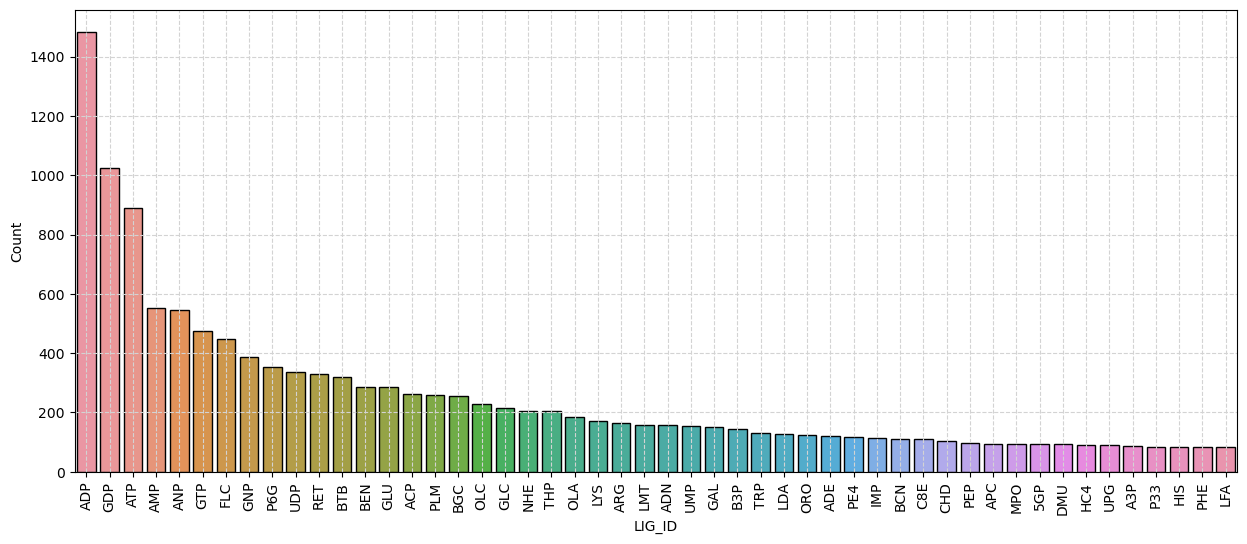

In [45]:
plot_common_ligands(small_lig_data)

It would seem that some important cofactors such as ATP, ADP, GDP, etc. are *not* included in the PDBe cofactor list!

In [46]:
cofactor_data = pd.DataFrame({'LIG_ID':pdb_with_cofactors['LIG_ID'].value_counts().index, 'Count':pdb_with_cofactors['LIG_ID'].value_counts()}).reset_index()
cofactor_data = pd.merge(cofactor_data, pdb_with_cofactors.drop_duplicates(subset='LIG_ID'))[['LIG_ID','LIG_NAME','LIG_SMILES','LIG_MW','Count']]

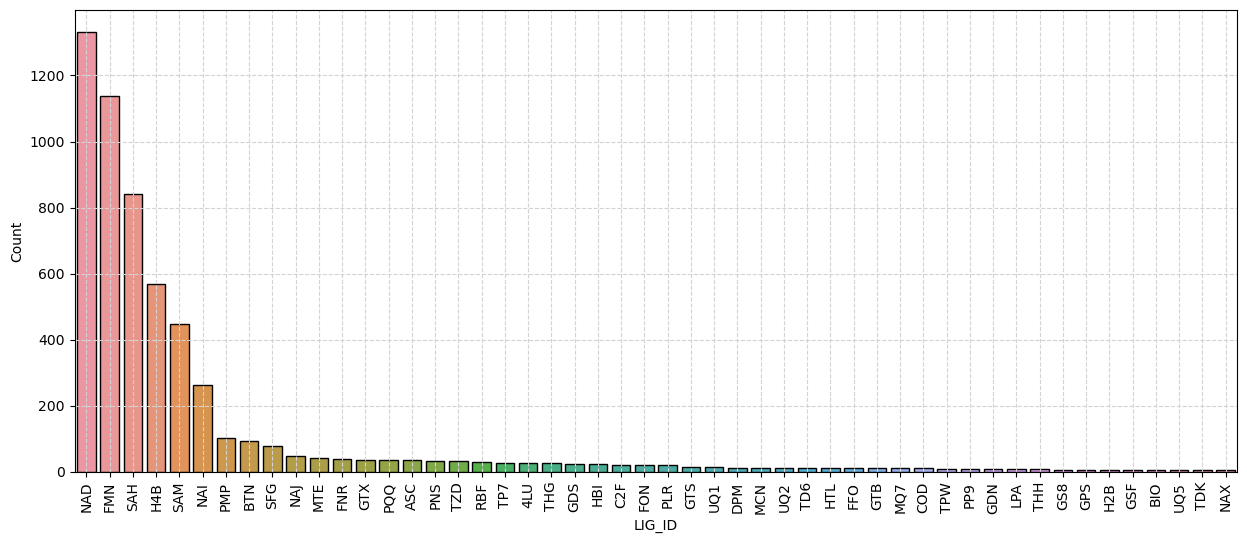

In [47]:
plot_common_ligands(cofactor_data)

In [48]:
# Total number of unique small ligands
len(small_lig_data.LIG_ID.unique())

25576

In [49]:
# Number of small ligands with only 1 PDB structure
len(small_lig_data[ small_lig_data.Count == 1])

20337

In [50]:
small_lig_data.to_csv('small_lig_data.csv', index=False)

In [51]:
# Number of unique cofactors
len(cofactor_data.LIG_ID.unique())

168

In [52]:
# Number of cofactors with only 1 structure in the database
len(cofactor_data[ cofactor_data.Count == 1 ])

65

In [53]:
small_lig_data.columns

Index(['LIG_ID', 'LIG_NAME', 'LIG_SMILES', 'LIG_MW', 'Count'], dtype='object')

In [54]:
cofactor_data.to_csv('cofactor_data.csv', index=False)

In [55]:
pdb_data.to_pickle('pdb_full_filtered.pkl')
pdb_with_cofactors.to_pickle('pdb_w_cofactors.pkl')
pdb_wout_cofactors.to_pickle('pdb_no_cofactors.pkl')

# **DONE HERE **

In [58]:
pdb_data.columns

Index(['PDB_ID', 'RESOLUTION', 'POLY_NAME', 'POLY_TYPE', 'POLY_CHAINS',
       'IS_MEMBRANE', 'LIG_ID', 'LIG_CHAINS', 'LIG_NAME', 'LIG_SMILES',
       'LIG_TYPE', 'LIG_MW', 'INVESTIGN?'],
      dtype='object')